### COVID-19 Analysis - Saudi Arabia

---
Sources: 
1.   https://github.com/alfozan/COVID-19-notebook
2.   https://github.com/CSSEGISandData/COVID-19
3.   http://91-divoc.com/pages/covid-visualization/
4.   https://datausa.io/coronavirus
5.   https://en.wikipedia.org/wiki/Coronavirus_disease_2019

Package Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
plt.style.use("seaborn")
pd.plotting.register_matplotlib_converters()

# Data sources


In [3]:
confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

df_confirmed_raw = pd.read_csv(confirmed_url)
df_deaths_raw = pd.read_csv(deaths_url)

In [4]:
# prepare dataframe
def clean_df(raw_df):
    col_rename = {"Province/State": "province", "Country/Region": "country"}
    cleaned_df = raw_df.rename(columns=col_rename)
    cleaned_df = cleaned_df.set_index(["country", "province"])
    cleaned_df = cleaned_df[[x for x in cleaned_df.columns if x not in ["Lat", "Long"]]]
    cleaned_df.columns = pd.to_datetime(cleaned_df.columns)
    cleaned_df.columns.name = "dt"
    return cleaned_df


df_confirmed = clean_df(df_confirmed_raw)
df_deaths = clean_df(df_deaths_raw)

## Basic Saudi COVID-19 plots

<ipython-input-5-9ccc40c2d869>:2: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  df_confirmed_saudi = df_confirmed.xs(["Saudi Arabia", np.NaN])
<ipython-input-5-9ccc40c2d869>:19: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  df_deaths_saudi = df_deaths.xs(["Saudi Arabia", np.NaN])


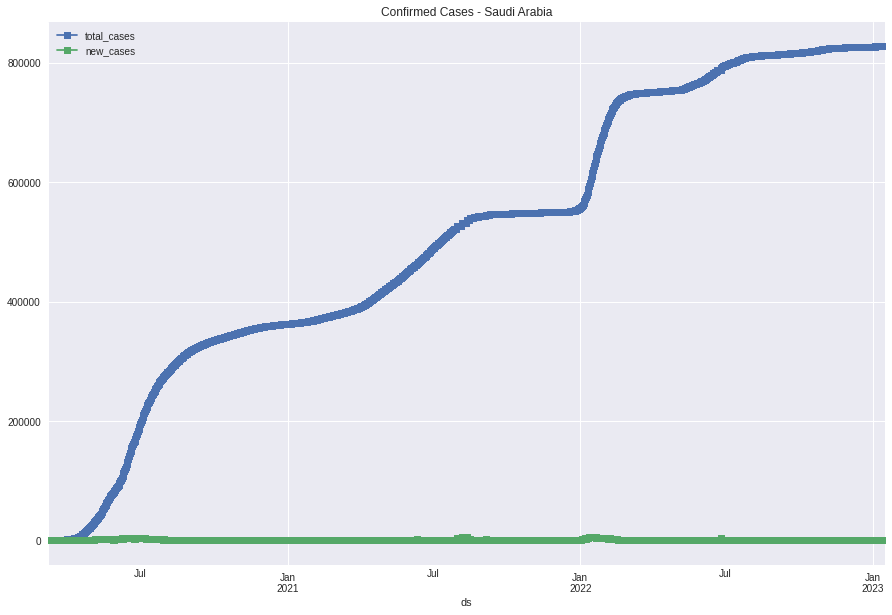

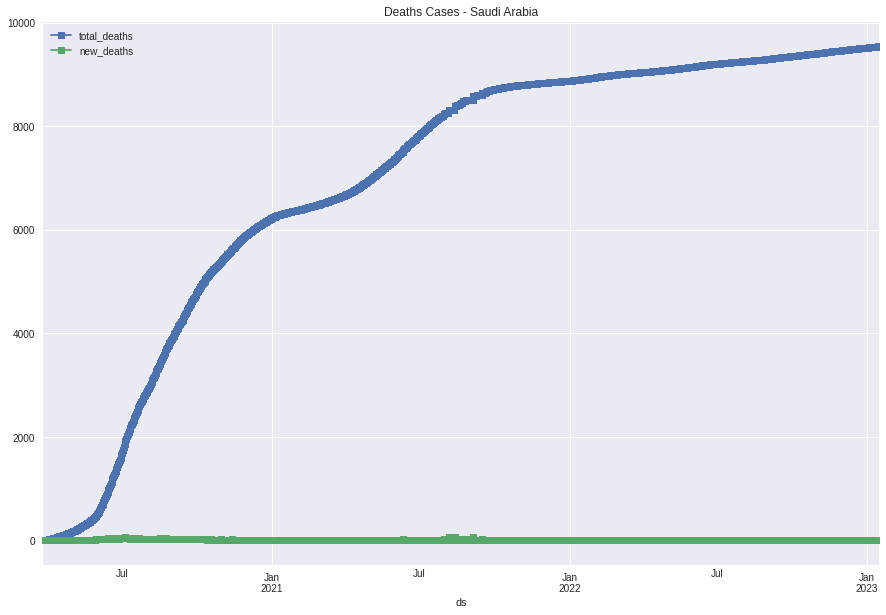

In [5]:
# load confirmed cases
df_confirmed_saudi = df_confirmed.xs(["Saudi Arabia", np.NaN])
df_confirmed_saudi = pd.DataFrame(
    {
        "ds": pd.to_datetime(df_confirmed_saudi.index),
        "total_cases": df_confirmed_saudi.values.astype("int32"),
    }
)
df_confirmed_saudi = df_confirmed_saudi[(df_confirmed_saudi["total_cases"] > 10)]
# calculate daily new cases
df_confirmed_saudi["new_cases"] = df_confirmed_saudi.diff()["total_cases"]

# plot confirmed cases
df_confirmed_saudi.plot(
    title="Confirmed Cases - Saudi Arabia", x="ds", figsize=(15, 10), marker="s"
)

# load deaths cases
df_deaths_saudi = df_deaths.xs(["Saudi Arabia", np.NaN])
df_deaths_saudi = pd.DataFrame(
    {
        "ds": pd.to_datetime(df_deaths_saudi.index),
        "total_deaths": df_deaths_saudi.values.astype("int32"),
    }
)
df_deaths_saudi = df_deaths_saudi[(df_deaths_saudi["total_deaths"] > 1)]
# calculate daily new cases
df_deaths_saudi["new_deaths"] = df_deaths_saudi.diff()["total_deaths"]

# plot death cases
df_deaths_saudi.plot(
    title="Deaths Cases - Saudi Arabia", x="ds", figsize=(15, 10), marker="s"
)

## COVID-19 Exponential Spread Comparison
Inspirations
- http://91-divoc.com/pages/covid-visualization/
- https://datausa.io/coronavirus


<ipython-input-6-b32e0ec40dea>:7: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  df_confirmed.xs([country, np.NaN]).values.astype("int32") for country in countries


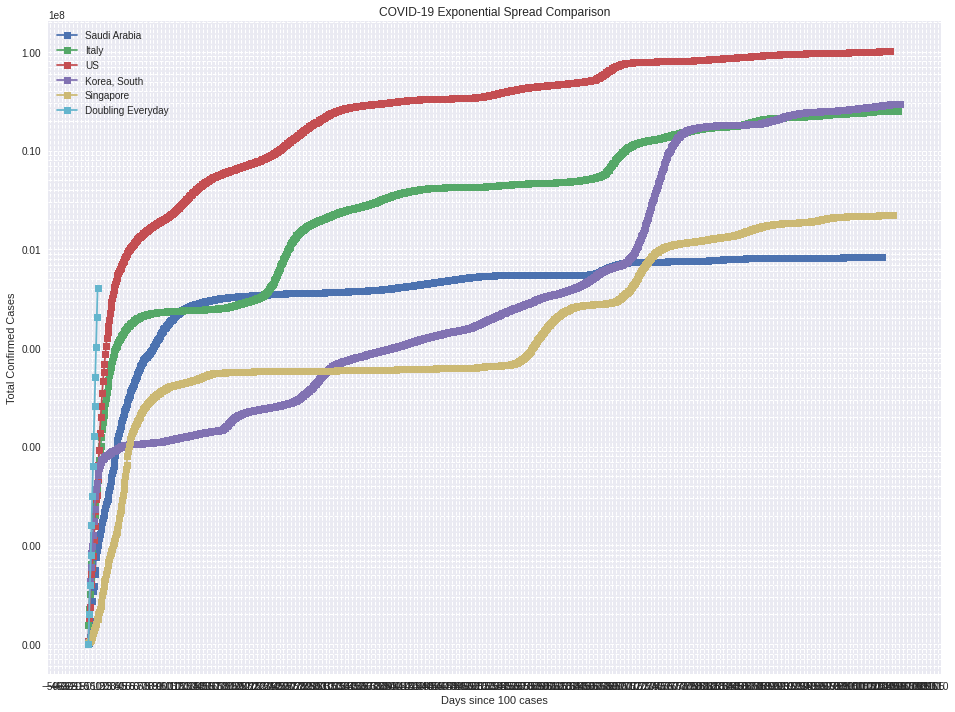

In [6]:
# comparison countries list
countries = ["Saudi Arabia", "Italy", "US", "Korea, South", "Singapore"]

lower_cases_cutoff = 100

countries_data = [
    df_confirmed.xs([country, np.NaN]).values.astype("int32") for country in countries
]
countries_data = [
    country[(country > lower_cases_cutoff)].tolist() for country in countries_data
]

# doubling every day trend
trend_double_every_day = [lower_cases_cutoff * 2 ** i for i in range(13)]
countries_data.append(trend_double_every_day)
countries.append("Doubling Everyday")

# pad
max_len = max([len(c) for c in countries_data])
countries_data = [
    country + [np.NaN] * (max_len - len(country)) for country in countries_data
]

total_cases_comparison = pd.DataFrame(
    np.stack(countries_data).T, index=range(max_len), columns=countries,
)

# plot
ax = total_cases_comparison.plot(
    title="COVID-19 Exponential Spread Comparison", figsize=(16, 12), marker="s"
)

# set chart options
plt.xlabel("Days since 100 cases")
plt.ylabel("Total Confirmed Cases")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# SEIR Epidemic Model

In [7]:
# basic SEIR model implementation
def SEIR_model(initial_conditions, model_parameters, days):
    # Susceptible, Exposed, Infected, Recovered
    S_0, E_0, I_0, R_0 = initial_conditions
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]

    sigma, beta, gamma = model_parameters
    for i in range(days):
        _beta = beta(i)

        next_S = S[-1] - (_beta * S[-1] * I[-1])
        next_E = E[-1] + (_beta * S[-1] * I[-1] - sigma * E[-1])
        next_I = I[-1] + (sigma * E[-1] - gamma * I[-1])
        next_R = R[-1] + (gamma * I[-1])
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)

    return pd.DataFrame(
        np.stack([S, E, I, R]).T,
        columns=["Susceptible","Exposed", "Infected", "Recovered"],
    )

In [8]:
# Helper function to plot simulation results
from matplotlib.ticker import FuncFormatter


def SEIR_chart(df, suptitle="", title=""):
    linecolors = ["#FC4F30", "#34656B", "#434344"]
    ax = df.plot.area(figsize=(16, 10), color=linecolors)

    legend_labels = df.columns.to_list()
    plt.suptitle(suptitle, size=20)
    plt.title(title, size=12)
    plt.legend(legend_labels, loc="center right", fontsize=20)

    formatter = FuncFormatter(lambda x, pos: "%1.0fM" % (x * 1e-6))
    ax.yaxis.set_major_formatter(formatter)
    plt.rcParams.update({"font.size": 16})


def SEIR_chart_extra_annotations(intervention_day):
    plt.text(0.74, 0.05, "Healthcare Capacity", transform=ax.transAxes, bbox=dict(facecolor="gray", alpha=0.7), fontsize=20)
    plt.axhline(y=1.5e6, color="b", linestyle="--", linewidth=2)

    plt.text(0.12, 0.7, "Intervention Day", transform=ax.transAxes, bbox=dict(facecolor="gray", alpha=0.7), fontsize=20, rotation=0)
    plt.axvline(x=intervention_day, color="black", linestyle="--", linewidth=2)

## SEIR Simulation for disease spread without any interventions
- deaths and severe cases are not modeled for simplicity


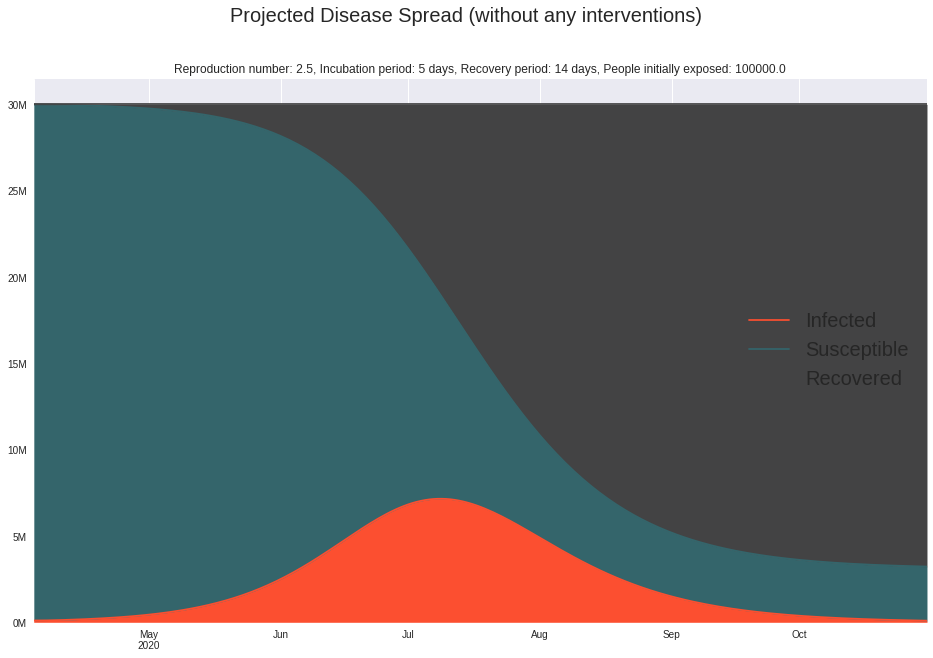

In [9]:
# Model parameters
incubation_period = 5
recovery_period = 14
reproduction_number = 2.5

# Model rates calculations
sigma = 1 / incubation_period
gamma = 1 / recovery_period
# beta = reproduction_number * gamma
beta = lambda _: reproduction_number * gamma

# Simulation parameters
simulation_duration = 7 * 30  # in days
population_size = 30e6

# Initial_conditions
start_date = pd.to_datetime("2020-04-04")
initial_exposed = 10e4  # 10k active cases
initial_infected = 0
initial_recovered = 0
init_vals = (
    1 - initial_exposed / population_size,
    initial_exposed / population_size,
    initial_infected,
    initial_recovered,
)

# Run simulation
results_df = SEIR_model(
    initial_conditions=init_vals,
    model_parameters=(sigma, beta, gamma),
    days=simulation_duration,
)
# Scale outputs by population size
results_df *= population_size
results_df = results_df.astype(int)
# Set date index
results_df.index = pd.date_range(
    start_date, start_date + pd.Timedelta(days=simulation_duration)
)

# Plotting
SEIR_chart(
    pd.DataFrame(
        {
            "Infected": results_df["Infected"] + results_df["Exposed"],
            "Susceptible": results_df["Susceptible"],
            "Recovered": results_df["Recovered"],
        }
    ),
    "Projected Disease Spread (without any interventions)",
    "Reproduction number: {}, Incubation period: {} days, Recovery period: {} days, People initially exposed: {}".format(
        reproduction_number, incubation_period, recovery_period, initial_exposed
    ),
)

In [10]:
results_df.head(10)

,Susceptible,Exposed,Infected,Recovered
2020-04-04,29900000,100000,0,0
2020-04-05,29900000,80000,20000,0
2020-04-06,29896440,67559,34571,1428
2020-04-07,29890288,60199,45613,3897
2020-04-08,29882172,56275,54395,7156
2020-04-09,29872497,54695,61765,11041
2020-04-10,29861514,54739,68292,15453
2020-04-11,29849375,55930,74362,20331
2020-04-12,29836163,57956,80236,25642
2020-04-13,29821913,60614,86097,31374


In [11]:
results_df.tail(10)

,Susceptible,Exposed,Infected,Recovered
2020-10-22,3153404,15083,122474,26709037
2020-10-23,3151105,14365,116742,26717785
2020-10-24,3148915,13682,111277,26726124
2020-10-25,3146829,13031,106065,26734073
2020-10-26,3144843,12412,101095,26741649
2020-10-27,3142950,11822,96356,26748870
2020-10-28,3141147,11260,91838,26755752
2020-10-29,3139430,10725,87530,26762312
2020-10-30,3137795,10216,83423,26768565
2020-10-31,3136236,9730,79508,26774523


## SEIR Simulations for disease spread WITH social interventions
Examples:
- Social distancing + personal hygiene awareness
- Contact tracing
- Close large gathering venues (i.e. schools) and limit travel and flights.


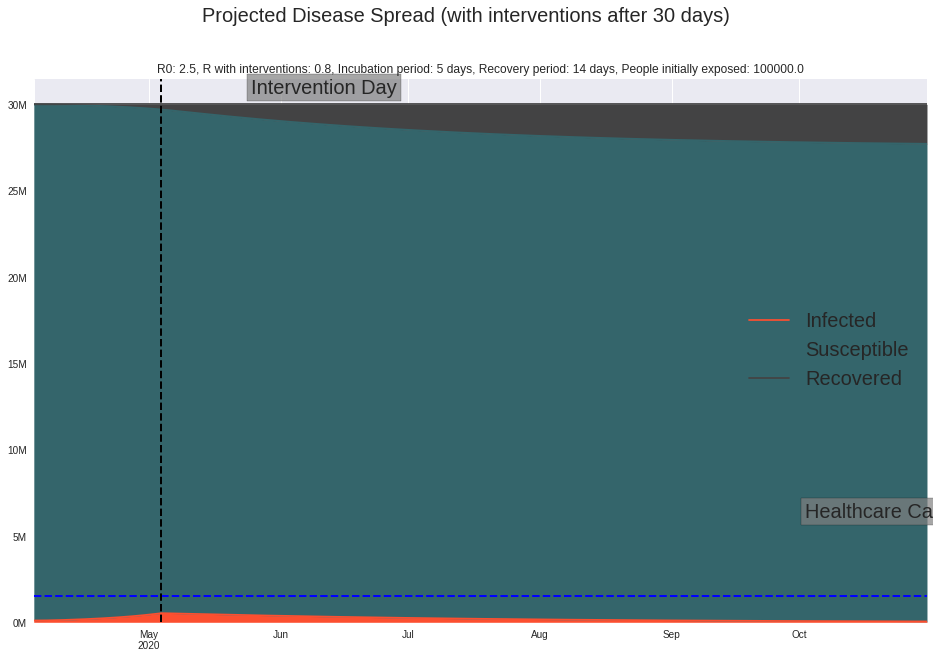

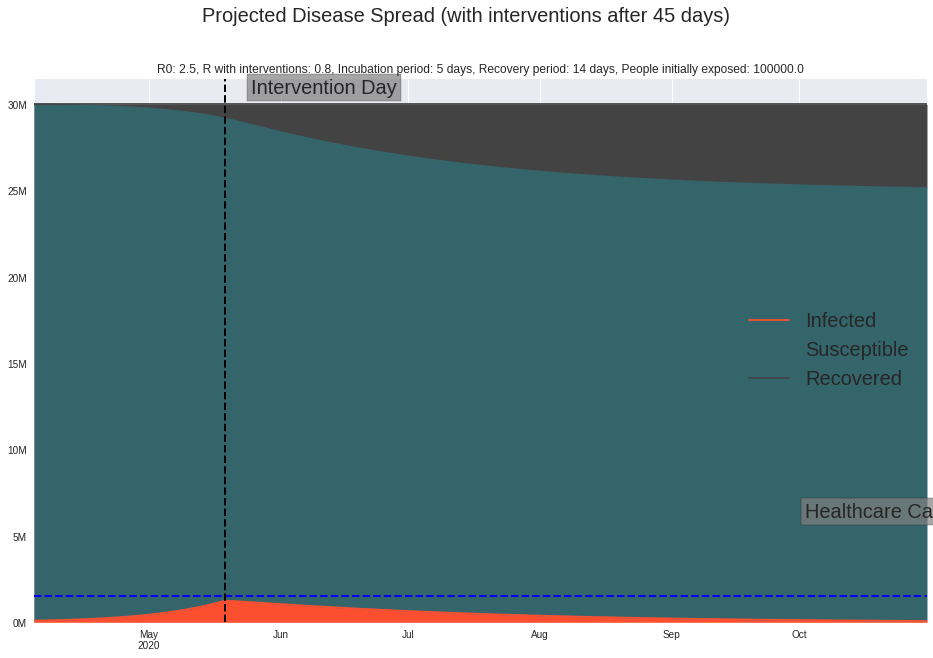

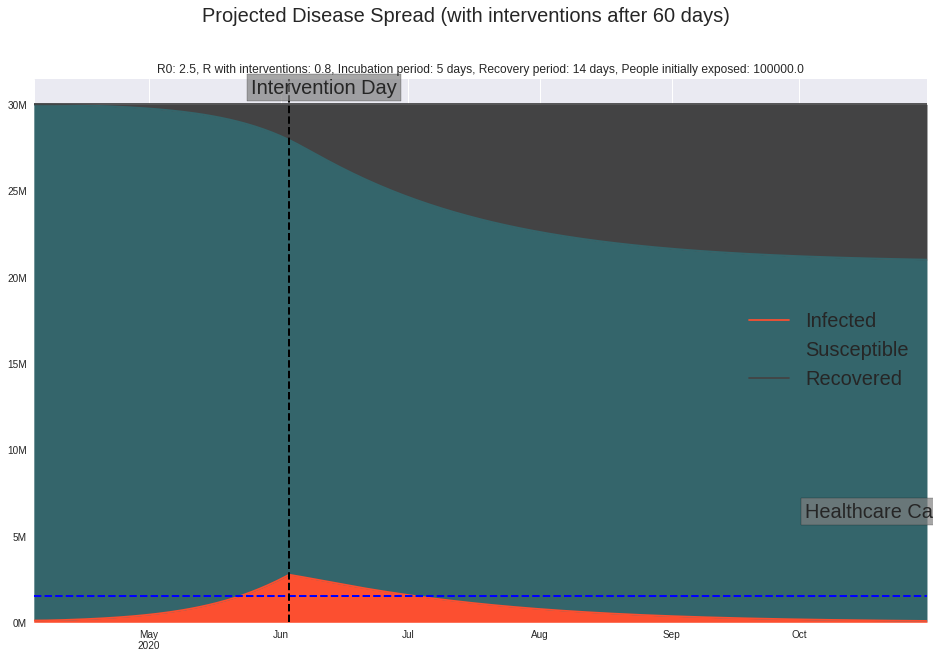

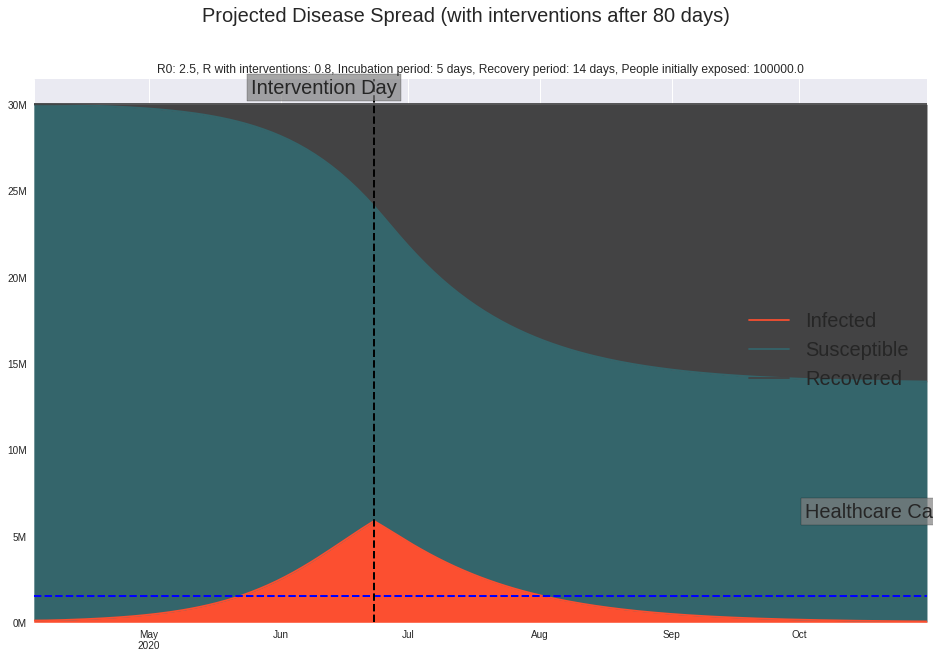

In [12]:
# Model parameters
reproduction_number_without_interventions = 2.5
reproduction_number_with_interventions = 0.80

intervention_days = [30, 45, 60, 80]
for intervention_day in intervention_days:
    # Model rates calculations
    beta = (
        lambda i: (reproduction_number_without_interventions * gamma)
        if i < intervention_day
        else (reproduction_number_with_interventions * gamma)
    )

    # Run simulation
    results_df = SEIR_model(
        initial_conditions=init_vals,
        model_parameters=(sigma, beta, gamma),
        days=simulation_duration,
    )
    # Scale outputs by population size
    results_df *= population_size
    results_df = results_df.astype(int)
    # Set date index
    results_df.index = pd.date_range(
        start_date, start_date + pd.Timedelta(days=simulation_duration)
    )

    # Plotting
    SEIR_chart(
        pd.DataFrame(
            {
                "Infected": results_df["Infected"] + results_df["Exposed"],
                "Susceptible": results_df["Susceptible"],
                "Recovered": results_df["Recovered"],
            }
        ),
        "Projected Disease Spread (with interventions after {} days)".format(
            intervention_day
        ),
        "R0: {}, R with interventions: {}, Incubation period: {} days, Recovery period: {} days, People initially exposed: {}".format(
            reproduction_number_without_interventions,
            reproduction_number_with_interventions,
            incubation_period,
            recovery_period,
            initial_exposed,
        ),
    )
    SEIR_chart_extra_annotations(
        pd.to_datetime(start_date + pd.Timedelta(days=intervention_day))
    )